# MTA Turnstile Data

The Metropolitan Transportation Authority (MTA) operates the New York City Subway. On their website, the MTA publishes [data from the turnstiles in its subway stations](http://web.mta.info/developers/turnstile.html). For each turnstile, passenger entries into and exits out of the subway station are logged accumulatively for four-hour periods: each turnstile has an entry and an exit counter and the data essentially provide the counter values every four hours.

In this notebook, we will first explore and prepare the turnstile data. Then we will determine the busiest stations and characterize stations as commuter origins or commuter destinations. Thereafter, we will explore the evolution of ridership over the course of the day and the year. Finally, we will build a linear regression model that reproduces the daily ridership.

[1. Data Exploration and Preparation](#data exploration)<br>
[2. Busiest Stations](#busiest stations)<br>
[3. Commute](#commute)<br>
[4. Ridership in a Day](#hourly_riders)<br>
[5. Ridership in a Year](#daily_ridership)<br>
[6. Regression Model](#model)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

First, some imports:

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.basemap import Basemap

# Data Exploration and Preparation <a id='data exploration'></a>

The data comes in indiviual files containing the turnstile data of one week. For now, we will explore one exemplary file from the week preceding 3/24/18.

In [3]:
data = pd.read_csv('turnstile_180324.txt')
# Fixes read-in problem of last column name:
data = data.rename(columns = {data.columns[-1]:'EXITS'}) 
# Remove irrelevant columns
data = data.drop(['DIVISION','DESC','LINENAME'], axis=1) 

In [4]:
data.shape[0]

197149

There are 197,149 samples in this data set.

In [5]:
data.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,03/17/2018,00:00:00,6552626,2219139
1,A002,R051,02-00-00,59 ST,03/17/2018,04:00:00,6552626,2219140
2,A002,R051,02-00-00,59 ST,03/17/2018,08:00:00,6552626,2219140
3,A002,R051,02-00-00,59 ST,03/17/2018,12:00:00,6552626,2219140
4,A002,R051,02-00-00,59 ST,03/17/2018,16:00:00,6552626,2219140


The columns `C/A`, `UNIT`, and `SCP` denote identifiers for a specific turnstile. `STATION` is the name of the subway station. `ENTRIES` and `EXITS` are the accumulated counter values of the turnstile (not the number of entries in the given time interval).

We will create additional columns to make data evaluation easier:

In [6]:
# Create timestamp column
data['timestamp'] = pd.to_datetime(data['DATE'] + ' ' + data['TIME'])

# Create column with length of interval since last data entry
data['interval'] = data['timestamp'] - data['timestamp'].shift(1)

# Calculate number of entries/exits in the preceding interval
data['ENTRY_DIFF'] = data['ENTRIES'] - data['ENTRIES'].shift(1)
data['EXIT_DIFF'] = data['EXITS'] - data['EXITS'].shift(1)

data.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,timestamp,interval,ENTRY_DIFF,EXIT_DIFF
0,A002,R051,02-00-00,59 ST,03/17/2018,00:00:00,6552626,2219139,2018-03-17 00:00:00,NaT,NaN,NaN
1,A002,R051,02-00-00,59 ST,03/17/2018,04:00:00,6552626,2219140,2018-03-17 04:00:00,04:00:00,0.0,1.0
2,A002,R051,02-00-00,59 ST,03/17/2018,08:00:00,6552626,2219140,2018-03-17 08:00:00,04:00:00,0.0,0.0
3,A002,R051,02-00-00,59 ST,03/17/2018,12:00:00,6552626,2219140,2018-03-17 12:00:00,04:00:00,0.0,0.0
4,A002,R051,02-00-00,59 ST,03/17/2018,16:00:00,6552626,2219140,2018-03-17 16:00:00,04:00:00,0.0,0.0


In order to better understand the structure of the data set, we can look at histograms for the time at which turnstile counter data are reported and the length of the reporting intervals.

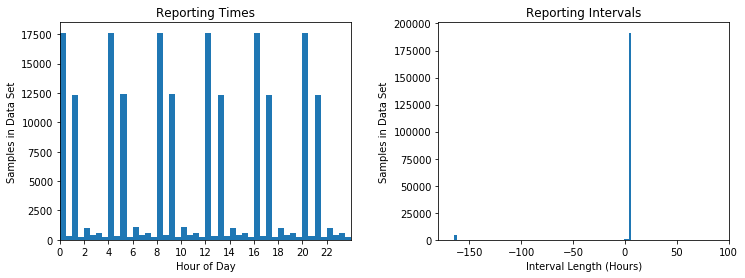

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,4), gridspec_kw={'wspace': 0.3})

#Plot histogram of times
ax[0].hist(data['TIME'].apply(pd.Timedelta) / pd.Timedelta('1 hour'), 
           bins=48)
ax[0].set_title('Reporting Times')
ax[0].set_xlabel('Hour of Day')
ax[0].set_xticks(range(24)[::2])
ax[0].set_xlim(0,24)
ax[0].set_ylabel('Samples in Data Set')

# Plot histogram of interval lengths
ax[1].hist(data['interval'].dropna() / pd.Timedelta('1 hour'), bins=100)
ax[1].set_title('Reporting Intervals')
ax[1].set_xlabel('Interval Length (Hours)')
ax[1].set_ylabel('Samples in Data Set')
plt.show()

Most reporting times come in four-hour intervals, but at two separate time sequences: a little more than half the reporting times are at 0, 4, 8, 12, 16, and 20 hours (using the 24-hour format) and a large amount of the rest are reported at 1, 5, 9, 13, 17, and 21 hours. 

There are a few samples with other reporting times but we will not take those into account. The small amount of reporting intervals of -168 hours are an artefact stemming from the time difference between the last sample of one turnstile and the first of the next turnstile. We will also eliminate those samples.

In the following, we <b>remove</b>:
- The first sample for each turnstile (we can't calculate the difference to the previous one)
- Samples with a negative number of entries or exits per interval
- Samples with more than 4000 entries/exits per interval (corresponds to 1 entry/exit in every 4 seconds, which is the highest frequency (aside from artifacts) found in the data)
- Samples with interval lengths that are not around 4 hours

In [8]:
# Remove first entry of each turnstile
data['NEW_SCP'] = ~ (data['SCP'] == data['SCP'].shift(1)) 
data = data[ (data['NEW_SCP']==False)
      # Remove negative no. of entries/exits:
      & (data['ENTRY_DIFF']>=0) & (data['EXIT_DIFF']>=0) # only positive entries/exits
      # Remove entry/exit rates that are too high
      & (abs(data['ENTRY_DIFF'])<4000) & (abs(data['EXIT_DIFF'])<4000)
      # Remove intervals that are not around 4 hours long
      & (data['interval']/pd.Timedelta('1 hour')>3.9) & (data['interval']/pd.Timedelta('1 hour')<4.5)
           ].drop('NEW_SCP', axis=1)

In [9]:
data.shape[0]

189301

After eliminating these anomalous samples, we are still left with 189,301 which is about 96% of the original samples.

Of the remaining, realistic entry/exit data, we can plot a histogram of the number of samples with a certain entry/exit frequency:

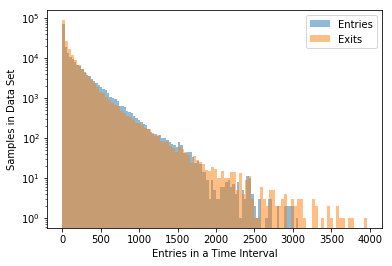

In [10]:
plt.hist(data['ENTRY_DIFF'], bins=100, alpha=0.5, label='Entries')
plt.hist(data['EXIT_DIFF'], bins=100, alpha=0.5, label='Exits')
plt.yscale('log', nonposy='clip')
plt.xlabel('Entries in a Time Interval')
plt.ylabel('Samples in Data Set')
plt.legend()
plt.show()

# Busiest Stations<a id='busiest stations'></a>

We now want to find out what the busiest stations are. For this purpose we will look at both entries and exits at any given station.

In [11]:
# Group data by station
total_riders = data.groupby(['STATION'], as_index=False) \
    [['ENTRY_DIFF','EXIT_DIFF']].sum()
# Columns for sum and difference of entries and exits
total_riders['TOTAL_DIFF'] = \
    total_riders['ENTRY_DIFF'] + total_riders['EXIT_DIFF']
total_riders['ENTRY_EXIT_DEFICIT'] = \
    total_riders['ENTRY_DIFF'] - total_riders['EXIT_DIFF']

The `total_riders` `DataFrame` contains the summed-up entries and exits for each station as well as their sum and difference. By sorting the `DataFrame` we can immediately tell the busiest stations. 34 St./Penn Station is the busiest with 1.7 million turnstile crossings in this week in March 2018.

In [12]:
total_riders.sort_values(by=['TOTAL_DIFF'], ascending=False).head()

,STATION,ENTRY_DIFF,EXIT_DIFF,TOTAL_DIFF,ENTRY_EXIT_DEFICIT
59,34 ST-PENN STA,893112.0,768412.0,1661524.0,124700.0
229,GRD CNTRL-42 ST,781770.0,698025.0,1479795.0,83745.0
57,34 ST-HERALD SQ,608904.0,572023.0,1180927.0,36881.0
45,23 ST,624999.0,459962.0,1084961.0,165037.0
14,14 ST-UNION SQ,580247.0,503932.0,1084179.0,76315.0


We now want to visualize the weekly ridership for each station on a map. The file `stations_conversion.csv` contains the geographic coordinates for each station. We will load these data and merge it with the `total_riders` `DataFrame`.

In [13]:
stations = pd.read_csv('stations_conversion.csv')

In [14]:
total_riders = pd.merge(total_riders, stations, on='STATION', how='inner')
total_riders.head()

,STATION,ENTRY_DIFF,EXIT_DIFF,TOTAL_DIFF,ENTRY_EXIT_DEFICIT,GTFS Latitude,GTFS Longitude
0,1 AV,129461.0,143324.0,272785.0,-13863.0,40.730953,-73.981628
1,103 ST,173796.0,116370.0,290166.0,57426.0,40.795379,-73.959104
2,103 ST-CORONA,117369.0,84928.0,202297.0,32441.0,40.749865,-73.862700
3,104 ST,13785.0,6985.0,20770.0,6800.0,40.688445,-73.841006
4,110 ST,58883.0,48748.0,107631.0,10135.0,40.795020,-73.944250


Now we can plot the stations as markers on a `Basemap` map with the size of the markers corresponding to the total ridership of the station. The data are displayed on a satellite image retrieved using `arcgisimage`.

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-74.19055,40.576127,-73.75540500000001,40.903125&bboxSR=4326&imageSR=4326&size=1500,1127&dpi=96&format=png32&f=image


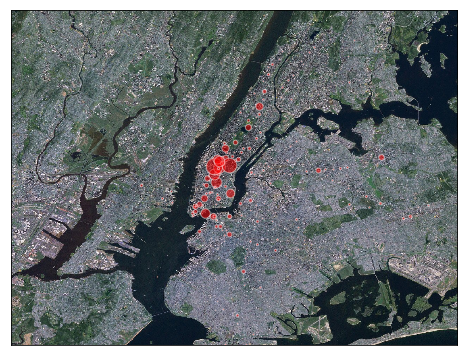

In [34]:
plt.figure(figsize=(8, 8))

# Create map with basemap
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat = total_riders['GTFS Latitude'].min(), 
            llcrnrlon = total_riders['GTFS Longitude'].min(),
            urcrnrlat = total_riders['GTFS Latitude'].max(), 
            urcrnrlon = total_riders['GTFS Longitude'].max())
# Load satellite image
m.arcgisimage(service='ESRI_Imagery_World_2D', 
              xpixels=1500, verbose=True)

# Draw stations with marker size according to ridership
for line in total_riders.iterrows():
    x,y = m(line[1]['GTFS Longitude'],line[1]['GTFS Latitude'])
    size = line[1]['TOTAL_DIFF'] / 100000
    plt.plot(x, y, 'o', markersize=size, color='red', alpha=0.5,
             markeredgewidth=1, markeredgecolor='white')
   
plt.show()

From this map visualization we can tell that the busiest stations are located in Manhattan, specifically in Midtown.

# Commute<a id='commute'></a>

Using the MTA ridership data, we can learn about commute in New York City by identifying stations that people commute <b>to</b> (commuter destinations) and stations that people commute <b>from</b> (commuter origins).

We create two subsets of the data, one for the morning (`data_am`) and one for the evening (`data_pm`), and group them by station. We then merge them and create a new column `am_pm_difference` that reflects the difference in ridership in the morning and in the evening at a given station. More preciesly, a large `am_pm_difference` arises from more entries in the morning or exits in the evening, as well as less entries in the evening and less exits in the morning.

In [22]:
# Morning data grouped by station
data_am = data[(data['TIME']=='08:00:00') | \
               (data['TIME']=='09:00:00')]\
               .groupby('STATION', as_index=False).sum()
# Evening data grouped by station
data_pm = data[(data['TIME']=='20:00:00') | \
               (data['TIME']=='21:00:00')]\
               .groupby('STATION', as_index=False).sum()

# Merge morning and evening data
commute = pd.merge(data_am, data_pm, on='STATION', suffixes=['am','pm'])

# Calculate difference
commute['am_pm_difference'] \
    = commute['ENTRY_DIFFam'] + commute['EXIT_DIFFpm'] \
    - commute['ENTRY_DIFFpm'] - commute['EXIT_DIFFam']

This difference (which is a measure for how many riders commute <b>from</b> this station) is plotted in the following histogram. It is immediately clear that more stations are commuter <i>origins</i> than commuter <i>destinations</i>.

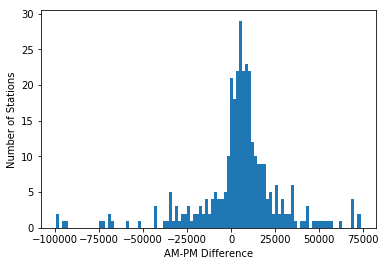

In [24]:
plt.hist(commute[abs(commute['am_pm_difference'])<100000]['am_pm_difference'], bins=100)
plt.xlabel('AM-PM Difference')
plt.ylabel('Number of Stations')
plt.show()

We now want to plot these data for each station. First, we exclude anomalous values. Then, we merge the `commute` `DataFrame` with the station locations and plot them using `Basemap`.

In [25]:
commute = commute[abs(commute['am_pm_difference'])<50000]

In [27]:
commute = pd.merge(commute, stations, on='STATION', how='inner')

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-74.073643,40.576127,-73.75540500000001,40.903125&bboxSR=4326&imageSR=4326&size=1500,1541&dpi=96&format=png32&f=image


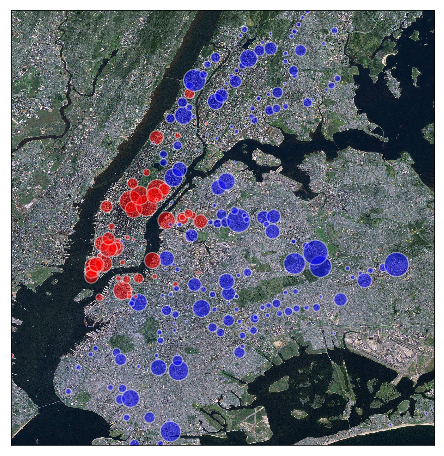

In [33]:
fig = plt.figure(figsize=(8, 8))

# Create map with basemap
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat = commute['GTFS Latitude'].min(), 
            llcrnrlon = commute['GTFS Longitude'].min(),
            urcrnrlat = commute['GTFS Latitude'].max(), 
            urcrnrlon = commute['GTFS Longitude'].max())
# Load satellite image
m.arcgisimage(service='ESRI_Imagery_World_2D', 
              xpixels = 1500, verbose= True)

# Draw stations with marker sizes according to AM-PM difference
for line in commute.iterrows():
    x,y = m(line[1]['GTFS Longitude'],line[1]['GTFS Latitude'])
    difference = line[1]['am_pm_difference']
    marker_size = 2000
    if difference > 0: # Commuter origins
        size = difference / marker_size
        color = 'blue'
    else:  # Commuter destinations
        size = - difference/ marker_size
        color = 'red'

    plt.plot(x, y, 'o', markersize=size, color=color, alpha=0.5,
             markeredgewidth=1, markeredgecolor='white')

plt.show()

# Ridership in a Day<a id='hourly_riders'></a>

Besides geographical information, we can also extract information about the temporal evolution of the ridership. In the following, we will look at the ridership of the whole subway system over the course of the day. We will look at data for the weekend and data for the weekdays separately and compare them.

First, we select the samples that give information on ridership on weekends and group them by the time of day the data were recorded.

In [35]:
# Select weekend data
data_weekend = data[(data['timestamp'].dt.dayofweek == 5)    # Saturday
                  | (data['timestamp'].dt.dayofweek == 6)]   # Sunday

In [36]:
# Select data that were recorded at 0, 4, 8, 12, 16, 20 hours
weekend_hourly = data_weekend[np.mod((data['TIME']\
                    .apply(pd.Timedelta)/pd.Timedelta('1 hour')),4)==0]
# Group data by time of the day
weekend_hourly = weekend_hourly.groupby('TIME').sum()
# Convert index to timestamp
weekend_hourly.index = pd.to_datetime(weekend_hourly.index)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Next, we do the same for the weekdays:

In [37]:
# Select weekday data
data_weekday = data[(data['timestamp'].dt.dayofweek != 5)   # Not Saturday
                  & (data['timestamp'].dt.dayofweek != 6)]  # Not Sunday

In [38]:
# Select data that were recorded at 0, 4, 8, 12, 16, 20 hours
weekday_hourly = data_weekday[np.mod((data['TIME']\
                    .apply(pd.Timedelta)/pd.Timedelta('1 hour')),4)==0]
# Group data by time of the day
weekday_hourly = weekday_hourly.groupby('TIME').sum()
# Convert index to timestamp
weekday_hourly.index = pd.to_datetime(weekday_hourly.index)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In order to be able to compare the ridership distributions throughout the day for weekend and weekdays, we create a new column containing the increase of ridership on weekends compared to weekdays (in percent of the weekday ridership).

In [39]:
weekend_hourly['INCREASE'] = \
    (weekend_hourly['ENTRY_DIFF']/2 - weekday_hourly['ENTRY_DIFF']/5) / \
                     (weekday_hourly['ENTRY_DIFF']/5) * 100

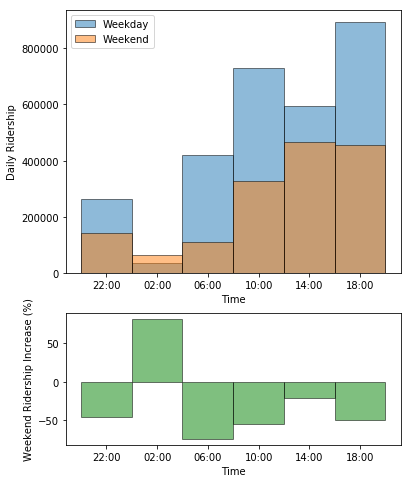

In [42]:
fig, ax = plt.subplots(2,1, figsize=(6,8))
grid = gridspec.GridSpec(2,1, hspace=0.2, wspace=0.2, height_ratios=[2,1])

# Plot ridership on weekdays and weekends
ax[0] = plt.subplot(grid[0])
# Weekdays
ax[0].bar(weekday_hourly.index.shift(-1, freq='4h'), 
          weekday_hourly['ENTRY_DIFF']/5, 
          width=1/6, align='edge', alpha=0.5, label='Weekday', 
          linewidth=1, edgecolor='black')
# Weekends
ax[0].bar(weekend_hourly.index.shift(-1, freq='4h'), 
          weekend_hourly['ENTRY_DIFF']/2, 
          width=1/6,  align='edge', alpha=0.5, label='Weekend', 
          linewidth=1, edgecolor='black')
ax[0].set_xticks(weekend_hourly.index.shift(-1, freq='2h'))
ax[0].set_xticklabels(weekend_hourly.index.shift(-1, freq='2h').strftime('%H:%M'))
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Daily Ridership')
ax[0].legend()

# Plot difference on weekends
ax[1] = plt.subplot(grid[1])
ax[1].bar(weekend_hourly.index.shift(-1, freq='4h'), 
          weekend_hourly['INCREASE'], 
          width=1/6, align='edge', alpha=0.5, label='Weekend', 
          color='green', linewidth=1, edgecolor='black')
ax[1].set_xticks(weekend_hourly.index.shift(-1, freq='2h'))
ax[1].set_xticklabels(weekend_hourly.index.shift(-1, freq='2h').strftime('%H:%M'))
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Weekend Ridership Increase (%)')
plt.show()

From these histograms, we can draw some basic conclusions about the ridership on the subway: first, more people use the subway on weekdays than on weekends. On weekdays, the busiest times are between 4-8pm and 8am-noon, reflecting rush hour commuter traffic. Very few riders travel between midnight and 4am.

On weekends, there are some notable changes to this pattern, as we can see most clearly from the relative ridership increase in the lower histogram. More riders travel at night time, i.e. between midnight and 4am. All other times see a decrease in ridership, which is most pronounced in the early morning, between 4-8am.

In summary, and not surprisingly, New York's subway riders stay out longer on the weekend and get up later than they do on weekdays.

### Local Differences in Hourly Ridership

The above analysis of ridership throughout the day is for the entirety of the MTA system. Different stations may have different ridership distributions over the course of the day. Here, we'll compare the ridership of 183 St station in the Bronx and that of Bedford Ave on the L train in Williamsburg.

First, we create a reference, the hourly ridership for the whole MTA system:

In [47]:
# Select data that were recorded at 0, 4, 8, 12, 16, 20 hours
data_hourly = data[np.mod((data['TIME'].apply(pd.Timedelta)/\
                           pd.Timedelta('1 hour')),4)==0]
# Group data by time of the day and convert index to timestamp
data_hourly = data_hourly.groupby('TIME').sum()
data_hourly.index = pd.to_datetime(data_hourly.index)

Now, the following function returns the difference between the hourly ridership distribution of a specified station and that of the overall MTA system. It returns the difference as a change in percentage points.

In [48]:
def comp_hourly(stop_name):
    
    # Select data that were recorded at 0, 4, 8, 12, 16, 20 hours
    # for a specified station 'stop_name'
    station_hourly = data[(np.mod((data['TIME'].apply(pd.Timedelta)\
                                   /pd.Timedelta('1 hour')),4)==0) 
                          & (data['STATION']==stop_name)]
    
    # Group data by time of the day and convert index to timestamp
    station_hourly = station_hourly.groupby('TIME').sum()
    station_hourly.index = pd.to_datetime(station_hourly.index)
    
    # Normalized ridership distribution for specified station
    this_station_norm = station_hourly['ENTRY_DIFF'] / \
                        station_hourly['ENTRY_DIFF'].sum()
        
    # Normalized ridership distribution for all stations
    average_norm = data_hourly['ENTRY_DIFF'] / \
                   data_hourly['ENTRY_DIFF'].sum()
        
    # Return deviation from average in percentage points
    return this_station_norm - average_norm

We can use the above function to compare any combination of stations, and particularly the above mentioned two stations in the Bronx and Williamsburg:

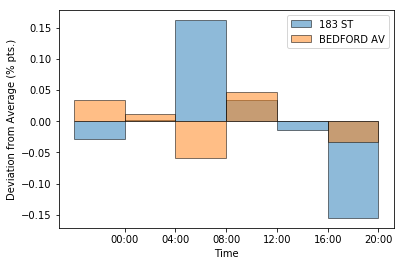

In [52]:
# Histogram for 183 St station
plt.bar(data_hourly.index.shift(-1, freq='4h'), 
        comp_hourly('183 ST'), 
        width=1/6,  align='edge', alpha=0.5, label='183 ST', 
        linewidth=1, edgecolor='black')
# Histogram for Bedford Av station
plt.bar(data_hourly.index.shift(-1, freq='4h'), 
        comp_hourly('BEDFORD AV'), 
        width=1/6,  align='edge', alpha=0.5, label='BEDFORD AV', 
        linewidth=1, edgecolor='black')
plt.xticks(data_hourly.index, data_hourly.index.strftime('%H:%M'))
plt.xlabel('Time')
plt.ylabel('Deviation from Average (% pts.)')
plt.legend()
plt.show()

The ridership distributions of both stations deviate from the average New York ridership in different ways. At Bedford Ave, les riders ride between 4-8am and 4-8pm, but these deficits are countered by ridership increases following these resepective intervals, at 8am-noon and 8pm-midnight. Bedford Ave riders' days seem shifted towards later hours.

The ridership at 183 St is quite different: Between the hours of 4-8am, they use the subway about 15 percentage points more than the average rider.

# Ridership in a Year<a id='daily_ridership'></a>

So far, we've been looking at the data for just one week. Now, we will look at multiple such data sets, giving us an overview of the ridership throughout a year.

The data are located as files (one per week) on the MTA website. In the following, we will download each file (the filenames are listed in `turnstile_data_filenames.txt`), process it to obtain the ridership throughout each day (similarly to above), and save the result in the `data_daily` `DataFrame`.

In [53]:
first=True

# Open each 
with open('turnstile_data_filenames.txt','r') as f:
    for line in f:
        filename = 'turnstile_'+str(line[0:6])+'.txt'
        address = 'http://web.mta.info/developers/data/nyct/turnstile/'\
                                                            +filename
        # Download file
        !curl -s -O {address}
   
        # Read file
        df = pd.read_csv(filename)

        # Process file        
        # # Calculate ridership per time interval
        df['ENTRY_DIFF'] = df['ENTRIES'] - df['ENTRIES'].shift(1)
        # # Remove first sample of each turnstile (can't get difference)
        df['NEW_SCP'] = ~ (df['SCP'] == df['SCP'].shift(1))
        df = df[ (df['NEW_SCP']==False) 
        # # Only allow positive number of entries
               & (df['ENTRY_DIFF']>=0)  
        # # Remove unreasonably high number of entries
               & (abs(df['ENTRY_DIFF'])<4000) 
                                 ].drop('NEW_SCP', axis=1)

        # Group samples by date
        df = df.groupby('DATE').sum()

        # Convert index to timestamp
        df.index = pd.to_datetime(df.index)

        # Append data to 'data_daily'
        if first==True:
            data_daily = df
        else:
            data_daily = pd.concat([data_daily,df])
        first=False
        
        # Delete file
        !rm {filename}
        print('Processed '+filename)

Processed turnstile_170401.txt
Processed turnstile_170408.txt
Processed turnstile_170415.txt
Processed turnstile_170422.txt
Processed turnstile_170429.txt
Processed turnstile_170506.txt
Processed turnstile_170513.txt
Processed turnstile_170520.txt
Processed turnstile_170527.txt
Processed turnstile_170603.txt
Processed turnstile_170610.txt
Processed turnstile_170617.txt
Processed turnstile_170624.txt
Processed turnstile_170701.txt
Processed turnstile_170708.txt
Processed turnstile_170715.txt
Processed turnstile_170722.txt
Processed turnstile_170729.txt
Processed turnstile_170805.txt
Processed turnstile_170812.txt
Processed turnstile_170819.txt
Processed turnstile_170826.txt
Processed turnstile_170902.txt
Processed turnstile_170909.txt
Processed turnstile_170916.txt
Processed turnstile_170923.txt
Processed turnstile_170930.txt
Processed turnstile_171007.txt
Processed turnstile_171014.txt
Processed turnstile_171021.txt
Processed turnstile_171028.txt
Processed turnstile_171104.txt
Processe

The resulting `DataFrame` contains one sample per day, containing the total ridership in the column `ENTRY_DIFF`:

In [54]:
data_daily.head()

,ENTRIES,EXITS,ENTRY_DIFF
DATE,,,
2017-03-25,635366026959,503934723087,2922129.0
2017-03-26,767985896143,609190016064,2686893.0
2017-03-27,793375660425,625752813393,5644572.0
2017-03-28,772291057192,611842263240,6025760.0
2017-03-29,776616163369,612200878237,6176843.0


In order to get an overview over long-term trends, we can resample the data to a weekly or monthly frequency.

In [74]:
weekly = data_daily.resample('W').sum()
monthly = data_daily.resample('M').sum()

In the following, we plot the daily ridership together with the weekly and monthly resampled data. We can make some observations from the evolution of the daily ridership: there is a strong weekly periodicity due to the lower ridership on weekends. Additionally, there is a reduction in overall ridership in the summer and around the winter holidays. Furthermore, there are a few individual days with dramatically decreased ridership, such as in early July: these occur on national holidays.

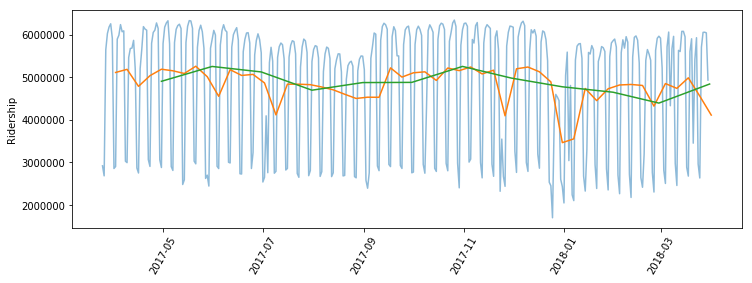

In [76]:
plt.figure(figsize=(12,4))
plt.plot(data_daily['ENTRY_DIFF'], alpha=0.5)    # ridership per day
plt.plot(weekly.iloc[1:,:]['ENTRY_DIFF']/7)      # ridership per week
plt.plot(monthly.iloc[1:,:]['ENTRY_DIFF']/30)    # ridership per month
plt.xticks(rotation=60)
plt.ylabel('Ridership')
#plt.xlim(pd.to_datetime('2017-12-15'), pd.to_datetime('2018-01-15'))
plt.show()

# Building a Model<a id='model'></a>

Finally, we want to build a simple model that is able to predict ridership on any given day. Our features will be the day of the week, key weather parameters, New York's school calendar and national holidays. We will then fit a linear regression model to our data.

### Weather data

We start with the weater data for New York. These data can be obtained from the NOAA. The accompanying documentation can be found [here](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf). The data set in `weather.csv` contains information from multiple New York station. Since we are only interested in the general weather trend for the whole city, we select the weather station at LaGuardia airport.

In [77]:
# Load weather data
weather = pd.read_csv('weather.csv')

# Select only LaGuardia airport weather information
weather_LGA = weather[weather['NAME']=='LA GUARDIA AIRPORT, NY US']

# Convert date column to timestamp
weather_LGA['DATE'] = weather_LGA['DATE'].apply(pd.to_datetime)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


From the date timestamp, we obtain the weekday for each day:

In [78]:
weather_LGA['weekday'] = weather_LGA['DATE'].dt.weekday

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [79]:
weather_LGA = weather_LGA.set_index('DATE')

We can now merge the ridership data in `data_daily` with the weather information in `weather_LGA`, but we will only merge the relevant columns from both `DataFrame`s. For the weather, we will select average wind speed (`AWND`), precipitation (`PRCP`), snowfall (`SNOW`), snow depth (`SNWD`), and average temperature (`TAVG`).

In [80]:
weather_entries = pd.merge(data_daily[['ENTRY_DIFF']], 
            weather_LGA[['weekday','AWND','PRCP','SNOW','SNWD','TAVG']], 
            left_index=True, right_index=True)

In [81]:
weather_entries.head()

,ENTRY_DIFF,weekday,AWND,PRCP,SNOW,SNWD,TAVG
DATE,,,,,,,
2017-03-25,2922129.0,5,8.72,0.00,0.0,0.0,54.0
2017-03-26,2686893.0,6,14.32,0.12,0.0,0.0,42.0
2017-03-27,5644572.0,0,8.50,0.20,0.0,0.0,42.0
2017-03-28,6025760.0,1,10.96,0.65,0.0,0.0,44.0
2017-03-29,6176843.0,2,12.75,0.00,0.0,0.0,49.0


The graphic below shows the ridership data in red and the daily precipitation in blue.

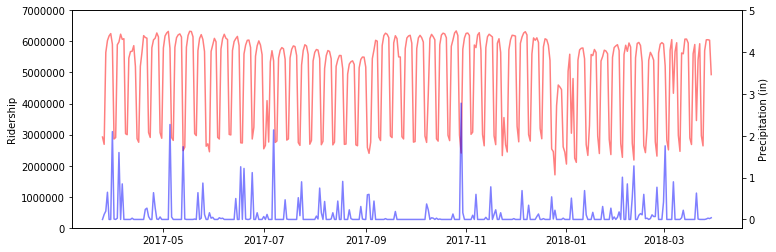

In [84]:
fig, ax = plt.subplots(1,1, figsize=(12,4))

# Ridership data
ax.plot(weather_entries['ENTRY_DIFF'], color='red', alpha=0.5)
ax.set_ylim(0,7000000)
ax.set_ylabel('Ridership')
ax.set_xticks

# Weather data
axR = ax.twinx()
axR.plot(weather_entries['PRCP'], color='blue', alpha=0.5)
axR.set_ylim(-0.2,5)
axR.set_ylabel('Precipitation (in)')

plt.show()

### Day-of-Week

The column `weekday` contains the information about the day of the week as a number ranging from 0 to 6, but for the linear regression model, we need to turn this information in to 7 separate features, i.e. 7 columns with each column containing values of 0 or 1 indicating whether it is the day represented by the column.

In [85]:
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for day in days:
       weather_entries[day] = (weather_entries['weekday'] == \
                               days.index(day)).astype(int)
weather_entries = weather_entries.drop('weekday', axis=1)

### Holidays

From the conspicuous dip in early July we can already tell that ridership is strongly influenced by national holidays. Here we load a list of national holidays and join this information with the other features.

In [86]:
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holiday_index = calendar.holidays('2017', '2019') # select 2017 and 2018
weather_entries = 
  weather_entries.join(pd.Series(1, index=holiday_index, name='holiday'))
weather_entries['holiday'].fillna(0, inplace=True)

### School Days

Additionally, the overall decrease of ridership in the summer and in late December is likely due to reduced rides by school children. In the following, we load a list that indicates which days were school days and join this information into the features.

In [87]:
school = pd.read_csv('school_days.csv')
school['DATE'] = school['DATE'].apply(pd.to_datetime)
school = school.set_index('DATE')
weather_entries = weather_entries.join(school)

The `weather_entries` `DataFrame` now contains all the features for our simple model (as well as the target, `ENTRY_DIFF`).

In [88]:
weather_entries.head()

,ENTRY_DIFF,AWND,PRCP,SNOW,SNWD,TAVG,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,school
DATE,,,,,,,,,,,,,,,
2017-03-25,2922129.0,8.72,0.00,0.0,0.0,54.0,0,0,0,0,0,1,0,0.0,0
2017-03-26,2686893.0,14.32,0.12,0.0,0.0,42.0,0,0,0,0,0,0,1,0.0,0
2017-03-27,5644572.0,8.50,0.20,0.0,0.0,42.0,1,0,0,0,0,0,0,0.0,1
2017-03-28,6025760.0,10.96,0.65,0.0,0.0,44.0,0,1,0,0,0,0,0,0.0,1
2017-03-29,6176843.0,12.75,0.00,0.0,0.0,49.0,0,0,1,0,0,0,0,0.0,1


### Linear Regression

We can now fit a linear regression model to the data. First, we split the data into features and target information:

In [89]:
we_feat = weather_entries.drop('ENTRY_DIFF', axis=1) # Features
we_target = weather_entries['ENTRY_DIFF']            # Target

Then we import the linear regression model from the `sklearn` module and fit it to the data.

In [90]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept = False)

model.fit(we_feat, we_target)
weather_entries['predicted'] = model.predict(we_feat)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Below we plot the ridership data in gray and overlay the fitted model in red. While there are still some deviations from the data, this simple model seems to capture the overall trends or the ridership data.

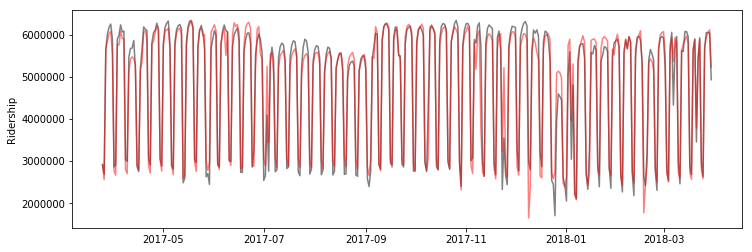

In [97]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(weather_entries['ENTRY_DIFF'], color='gray', alpha=1)
ax.plot(weather_entries['predicted'], color='red', alpha=0.5)
ax.set_ylabel('Ridership')
#ax.set_xlim(pd.to_datetime('2017-06-15'), pd.to_datetime('2017-07-15'))
ax.set_xticks
plt.show()

Specifically, it even captures the behavior in late December, which is a particularly anomalous period of time.

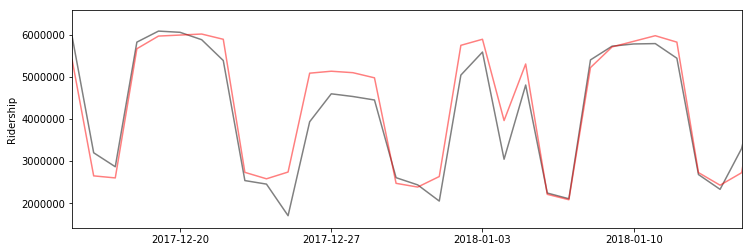

In [98]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(weather_entries['ENTRY_DIFF'], color='gray', alpha=1)
ax.plot(weather_entries['predicted'], color='red', alpha=0.5)
ax.set_ylabel('Ridership')
ax.set_xlim(pd.to_datetime('2017-12-15'), pd.to_datetime('2018-01-15'))
ax.set_xticks
plt.show()

By looking at the coefficients of our model, we can gain some specific insight into the contribution of each features. For example, each inch of precipitation seems to prompt 41,000 less subway rides. Every degree Fahrenheit increases ridership by 3,200. National holidays prompt about 2 million riders less to take the subway.

In [737]:
pd.Series(model.coef_, index=we_feat.columns).round(1)

AWND             631.4
PRCP          -40716.7
SNOW          -36379.2
SNWD          -24132.4
TAVG            3235.0
Mon           169495.6
Tue           -62243.3
Wed          -115504.6
Thu           -37177.6
Fri           -38883.5
Sat           117908.7
Sun            96470.8
predicted          0.9
holiday     -2077455.9
school        708084.8
dtype: float64